Predicting UP IR flux, large errors from using all the layers now

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
DS_a = xr.open_dataset('af') #dataset of auxhist
DS_w = xr.open_dataset('wf') #dataset of wrfout

In [3]:
#Temperature:
T = (DS_w.T.values + DS_w.T0) * ((DS_w.P.values + DS_w.PB.values)/DS_w.P0)**(DS_w.R_D/DS_w.CP)
T.shape

(71, 52, 36, 72)

In [4]:
T[5,:,18,0] #temperature goes from lowest hieght to highest hieght

array([242.71082 , 237.8069  , 236.24007 , 235.12848 , 234.2799  ,
       233.52779 , 232.82172 , 232.14073 , 231.47406 , 230.81564 ,
       229.99742 , 229.01949 , 228.03973 , 227.05513 , 225.73048 ,
       224.05423 , 220.9039  , 215.62561 , 209.97517 , 208.85222 ,
       206.90262 , 204.41917 , 200.12592 , 195.17355 , 189.94121 ,
       186.28903 , 183.58492 , 180.31416 , 176.13753 , 171.68274 ,
       167.32304 , 163.81029 , 160.24342 , 155.59138 , 150.58986 ,
       146.3529  , 142.94057 , 139.79279 , 136.59853 , 133.4877  ,
       131.82347 , 138.27815 , 160.04852 , 173.36342 , 169.7645  ,
       162.5508  , 155.04514 , 147.05397 , 139.96574 , 138.28108 ,
       119.210464, 138.57014 ], dtype=float32)

In [5]:
st = DS_w.TSK.values #surface temp
st.shape

(71, 36, 72)

In [6]:
d_c = DS_w.TAU_OD.values #dust optical depth
d_c.shape 

(71, 52, 36, 72)

In [7]:
d_c2 = DS_w.TAU_OD2D.values
d_c2.shape

(71, 36, 72)

In [8]:
em = DS_w.EMISS.values #emissivity
em.shape 

(71, 36, 72)

In [9]:
uif = DS_a.UPIRFLUX.values[1:,10,:,:] #look at up visual flux on 10th layer
uif.reshape(-1).shape

(181440,)

In [10]:
sla = [] #special layer arrays that are the feature vectors in the linear regression model
sla.append((em*st**4).reshape(-1)) #don't have overall opacity, will deal with this issue later
for i in range(52): #using all the layers now
    sla.append((np.exp(-d_c[:,i,:,:])*T[:,i,:,:]**4).reshape(-1))
sla = np.array(sla)
sla = sla.T[2592:,:] #take transpose, remove first day of data (all lwr are 0 there)


In [11]:
sla.shape

(181440, 53)

# Trying linear regression first

In [12]:
from sklearn.linear_model import LinearRegression
uif_out = uif.reshape(-1)
lr1 = LinearRegression()
lr1.fit(sla,uif_out)
uif_lin = lr1.predict(sla) #predicted

In [13]:
lr1.coef_

array([ 3.2620083e-08,  3.9559485e-08, -2.1152175e-08,  2.3358373e-09,
       -1.2801502e-09,  4.3212953e-09, -7.9110052e-10, -1.3761055e-09,
       -1.0415167e-08,  1.5954360e-08, -5.7377676e-09,  2.3631220e-08,
       -9.8093089e-08,  2.1947859e-07, -1.7726087e-07, -2.1013385e-08,
        1.4267022e-07, -9.6975967e-08,  1.6566727e-08, -2.4537385e-09,
       -3.2323477e-09, -2.1658785e-08,  2.1171328e-08, -1.5652247e-08,
        3.0085054e-08, -7.0164660e-08,  1.1490437e-07, -1.1955638e-07,
        1.3405088e-07, -1.5200024e-07,  1.6421868e-07, -1.3577684e-07,
        8.1931745e-08, -4.8646015e-08,  4.2769486e-08, -2.6181347e-08,
        1.6831756e-08, -6.2863137e-09, -6.6414678e-09,  3.9107206e-09,
        9.6563504e-09, -8.2992671e-09,  3.5717171e-09, -2.2224711e-10,
       -3.6834713e-09, -1.6905588e-09,  2.9401193e-09, -2.7645974e-09,
        1.5198385e-09, -1.0921539e-09,  5.8051697e-09, -5.1070153e-09,
        3.1899958e-09], dtype=float32)

In [14]:
from sklearn.metrics import mean_squared_error

lin_mse = mean_squared_error(uif_out, uif_lin)
lin_rmse = np.sqrt(lin_mse)
lin_rmse 

7.161956

In [15]:
np.min(uif_out)

15.638899

In [16]:
np.max(uif_out)

412.3086

In [17]:
uif_diff = uif_out - uif_lin

In [18]:
np.where(uif_diff == np.min(uif_diff))

(array([122045], dtype=int64),)

In [19]:
uif_out[92295]

147.35765

In [20]:
uif_lin[92295] #some pretty big differences...

179.43094

In [21]:
np.where(uif_diff > 50)

(array([  4113,   9297,  14481,  17073,  19665,  22257,  24849,  27441,
         30033,  32625,  35217,  37809,  40401,  42993,  45585,  48177,
         50769,  53361,  55953,  58545,  61137,  63729,  66321,  68913,
         71505,  74097,  76689,  79281,  81873,  87057,  92241,  94833,
         97425, 100017, 102609, 105201, 107793, 112977, 144081, 146673,
        151857, 162225, 175185, 180369], dtype=int64),)

<function matplotlib.pyplot.show(*args, **kw)>

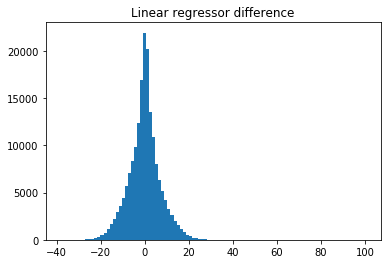

In [22]:
plt.hist(uif_diff, bins = 100)
plt.title("Linear regressor difference")
plt.show #some variance...

In [23]:
uif_out.reshape(-1,1).shape

(181440, 1)

In [24]:
sla[:10*36*72,:].shape

(25920, 53)

In [25]:
sla[10*36*72:11*36*72,:]

array([[3.2982371e+08, 4.3012157e+08, 4.3130067e+08, ..., 2.3412691e+08,
        2.1674832e+08, 2.1496277e+08],
       [3.2989165e+08, 4.3018813e+08, 4.3141155e+08, ..., 2.3753515e+08,
        2.2025200e+08, 2.1499749e+08],
       [3.2991754e+08, 4.3020230e+08, 4.3146352e+08, ..., 2.4122179e+08,
        2.2397907e+08, 2.1495376e+08],
       ...,
       [1.7091520e+09, 1.5555758e+09, 1.5599835e+09, ..., 7.7389216e+08,
        8.3620032e+08, 6.6332077e+08],
       [1.7200332e+09, 1.5640590e+09, 1.5681286e+09, ..., 7.7153069e+08,
        8.3414899e+08, 6.6392493e+08],
       [1.7308575e+09, 1.5723578e+09, 1.5760733e+09, ..., 7.6968621e+08,
        8.3303002e+08, 6.6487891e+08]], dtype=float32)

In [26]:
real_out = uif_out[10*36*72:11*36*72].reshape(36,72)
pred_out = uif_lin[10*36*72:11*36*72].reshape(36,72)

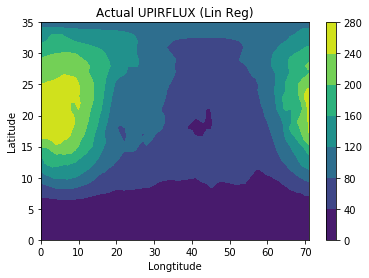

In [27]:
plt.contourf(real_out)
plt.colorbar()
plt.title("Actual UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

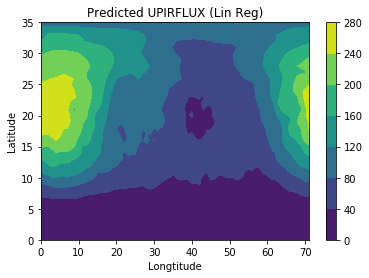

In [28]:
plt.contourf(pred_out)
plt.colorbar()
plt.title("Predicted UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

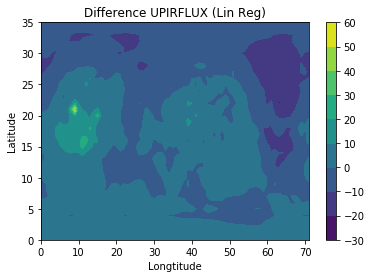

In [29]:
plt.contourf(real_out - pred_out)
plt.colorbar()
plt.title("Difference UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

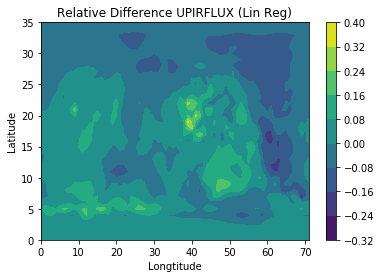

In [30]:
plt.contourf((real_out - pred_out)/real_out)
plt.colorbar()
plt.title("Relative Difference UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

## Getting the integrals of flux error (and then getting average erroneusly added flux)

In [31]:
def int_err(pred, real, real_in, r): 
    areas = []
    for i in range(len(real)):
        dA =  -r**2 * np.sin((np.pi/36)*((real_in.index[i]//72)%36)) * (np.pi/36) * (np.pi/36)  #area increment
        areas.append(dA)
    areas = np.array(areas)
    return np.sum((np.array(pred) - np.array(real))*areas)

In [32]:
real_out.shape

(36, 72)

In [36]:
lin_errors = []
for i in range(70):
    lin_int_err = int_err(uif_lin[i*36*72:(i+1)*36*72], uif_out[i*36*72:(i+1)*36*72], pd.DataFrame(uif_lin), 3.39e6) #make sure the errors work by integrating a sphere's surface
    lin_errors.append(lin_int_err/(1.44e14)) #reasonably large

In [37]:
lin_errors = np.array(lin_errors)
lin_errors

array([ 0.22517229,  0.04754081,  0.04009421, -0.0107618 , -0.16498785,
       -0.21350751, -0.37952145, -0.5908587 , -0.53495993, -0.58707641,
       -0.63453322, -0.73415731, -0.77804416, -0.74418637, -0.82716026,
       -0.86268676, -0.89263718, -0.90786069, -0.92794668, -0.93138676,
       -0.9352521 , -0.95199564, -0.9492223 , -0.95600295, -0.92476388,
       -1.00123271, -0.90423797, -0.90892553, -0.80572681, -0.59591344,
       -0.50720463, -0.47721762, -0.31552149, -0.22802014, -0.0540259 ,
        0.15589183,  0.31873719,  0.45917703,  0.97741768,  1.42458995,
        1.87484013,  2.2726296 ,  2.6859474 ,  3.46371662,  3.79338756,
        4.04270804,  4.13392059,  4.85722676,  3.82826543,  3.59273921,
        3.1355956 ,  2.72621858,  2.11729457,  2.02827088,  2.04131495,
        1.4940584 ,  0.73126958,  1.04174522,  1.05769949,  0.56451824,
        0.3990776 ,  0.29982708,  0.44515353,  0.39084355,  0.6237614 ,
        0.66223134,  0.56039677,  0.58635569,  0.63616583,  0.70

In [38]:
np.min(lin_errors)

-1.0012327127642848

In [39]:
np.max(lin_errors) 

4.85722675519773

The minimums and maximums are still sizable compared to the average, but noticeably smaller than when predicting using the first 10 layers.

In [40]:
np.average(lin_errors)

0.5600476188214495

In [41]:
np.std(lin_errors)

1.527894920500107

Although the average is slightly bigger, the standard deviation is much smaller than before (just like the extremes), so using all the layers to predict the upward infrared flux is better than just the layers under the current upward infrared flux layer that is being predicted.